<a href="https://colab.research.google.com/github/hank199599/deep_learning_keras_log/blob/main/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 影像訓練卷積神經網路

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import layers
from keras import models
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))

## 參數的算法
參數 = 過濾器長*寬*輸入通道數*過濾器個數+過濾器個數

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


最後一個Conv2D層輸出的2D張量必須送到接觸的分類器神經網路  
故需要將3D張量展平為1D張量，才能進行傳遞

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [8]:
from keras import layers
from keras import models


(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32')/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_images,train_labels,epochs=5,batch_size=64)

11493376/11490434 [==============================] - 354s 31us/step
Epoch 1/5
938/938 [==============================] - 20s 13ms/step - loss: 0.3957 - accuracy: 0.8772
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0510 - accuracy: 0.9837
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0354 - accuracy: 0.9888
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0250 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0190 - accuracy: 0.9940


運用測試資料來驗證準確度

In [9]:
test_loss,test_acc = model.evaluate(test_images,test_labels)
test_acc

313/313 [==============================] - 2s 5ms/step - loss: 0.0285 - accuracy: 0.9912


0.9911999702453613

# 卷積層

## 比較
* **密集層**：學習特徵空間中全域的Pattern
* **卷積層**：學習局部的pattern

> 特徵映射圖亦被稱作特徵圖：他本身是一個抽象映射動作  
  
![pic5-1](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-1.png?raw=true)

## 定義
* 從輸入採樣的區塊大小
* 輸出特徵圖的深度  
　　　　　↓ filter數量　　　　 ↓ 以tuple或list傳入
```python
Conv2D(output_depth,(widow_height,window_width))
```  


## 運作原理
1. 在3D輸入特徵圖上滑動的小窗格，萃取窗格上的3D區塊的特徵  
2. 將每個3D區塊轉換成做張量**shape=(output_depth,)**的1D張量
3. 將所有向量依照空間上的位置排列重新組裝成**shape=(height,width,output_depth)**的3D輸出特徵圖  

> 輸出特徵圖中的每個空間位置和輸入特徵圖中的相同位置相對應  

![pic5-2](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-2.png?raw=true)

## 可能的問題


### 邊界效應 border effec
![pic5-3](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-3.png?raw=true)  
透過窗格的滑動萃取特徵圖的同時，  
會使輸出的向量維度發生縮減的情形。

**解決方式**：填補法(padding)  
在輸入特徵圖的每一側增加適當數量的列和行，以便讓每個輸入圖塊都可以讓卷積層的移動窗格掃描到。
```
在Conv2D層中，使用padding參數來設定  
* vaild ；不用填補
* same ： 使用填補方式使輸出輸入具有相同的寬度和高度
```


### 步長(stride)
控制窗格移動的間距  
依此方式進行取樣的卷積層被稱作「**步長設定卷積層**(strided convolutions)」
> 即步長大於1的卷積層


# Maxpooling
從輸入特徵圖中做採樣並輸出樣本的最大值。  
他並非用卷積核(convolution kernel)張量積的方式來轉換的局部區塊


In [10]:
from keras import layers
from keras import models
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model_no_max_pool.add(layers.Conv2D(64,(3,3),activation='relu'))
model_no_max_pool.add(layers.Conv2D(64,(3,3),activation='relu'))

In [11]:
model_no_max_pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


# 少量資料從頭訓練
易發生 **overfiting**
* 資料擴增法 (data augmentation)
* 預先訓練神經網路的特徵萃取法 (feature extration with a pretrained network)
* 微調預先訓練神經網路法 (fine-tuning a pretrained network)  
  [這段操作在本機端上執行]

1.建立基礎資料夾

In [1]:
import os,shutil

original_dataset_dir=r'dogs-vs-cats\train'

# 建立基礎資料集路徑
base_dir=r'data\cats_and_dogs_small'
if not os.path.isdir(base_dir):os.mkdir(base_dir)

# 建立訓練資料集路徑
train_dir=os.path.join(base_dir,'train')
if not os.path.isdir(train_dir):os.mkdir(train_dir)

# 建立驗證資料集路徑
validation_dir=os.path.join(base_dir,'validation')
if not os.path.isdir(validation_dir):os.mkdir(validation_dir)

# 建立測試資料集路徑
test_dir=os.path.join(base_dir,'test')
if not os.path.isdir(test_dir):os.mkdir(test_dir)


2.建立貓與狗各自的資料夾

In [2]:
# 建立訓練資料集的貓/狗路徑
train_cats_dir=os.path.join(train_dir,'cats')
if not os.path.isdir(train_cats_dir):os.mkdir(train_cats_dir)

train_dogs_dir=os.path.join(train_dir,'dogs')
if not os.path.isdir(train_dogs_dir):os.mkdir(train_dogs_dir)

# 建立驗證資料集的貓/狗路徑
validation_cats_dir=os.path.join(validation_dir,'cats')
if not os.path.isdir(validation_cats_dir):os.mkdir(validation_cats_dir)

validation_dogs_dir=os.path.join(validation_dir,'dogs')
if not os.path.isdir(validation_dogs_dir):os.mkdir(validation_dogs_dir)

# 建立測試資料集的貓/狗路徑
test_cats_dir=os.path.join(test_dir,'cats')
if not os.path.isdir(test_cats_dir):os.mkdir(test_cats_dir)

test_dogs_dir=os.path.join(test_dir,'dogs')
if not os.path.isdir(test_dogs_dir):os.mkdir(test_dogs_dir)


3.將「cat」圖片進行分組並轉移到對應的資料夾

In [49]:
fnames=['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)

fnames=['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)

fnames=['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)

In [50]:
fnames=['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_dogs_dir,fname)
    shutil.copyfile(src,dst)

fnames=['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)

fnames=['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)

進行檢查：驗證每個訓練/驗證/測試分組中的圖片數量

In [3]:
print("訓練用的貓圖片張數：",len(os.listdir(train_cats_dir)))
print("訓練用的狗圖片張數：",len(os.listdir(train_dogs_dir)))
print("驗證用的貓圖片張數：",len(os.listdir(validation_cats_dir)))
print("驗證用的狗圖片張數：",len(os.listdir(validation_dogs_dir)))
print("測試用的貓圖片張數：",len(os.listdir(test_cats_dir)))
print("測試用的狗圖片張數：",len(os.listdir(test_dogs_dir)))

訓練用的貓圖片張數： 1000
訓練用的狗圖片張數： 1000
驗證用的貓圖片張數： 500
驗證用的狗圖片張數： 500
測試用的貓圖片張數： 500
測試用的狗圖片張數： 500


# 建立神經網路

 組成多個 Conv2D + MaxPolling2D 增強神經網路的能量並降低特徵圖的大小。  
 自 150x150 在最後展平前得到 7x7 的特徵圖。  
 由於欲解決的問題是**二元問題**，  
 因此使用單一單元和sigmoid啟動函數來結束神經網路。

In [20]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

由於使用單個Sigmoid單元結束神經網路，  
因此使用二元交叉熵作為損失基準

In [21]:
from keras import optimizers

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

# 資料預處理步驟
1. 讀取影像檔案
2. 將JPEG內容解碼為RGB的像素
3. 將 RGB像素轉換成浮點數張量
4. 將像素值(0-255之間)壓縮到 [[0,1]] 區間  

實務上：  
```python
keras.perprocesssing.image 之中的 ImageDataGenerator 類別
```

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'     # 因為二元交叉熵binary_crossentropy作為損失值，所以需要二元標籤
)

validation_generator=test_datagen.flow_from_directory(
    test_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'     # 因為二元交叉熵binary_crossentropy作為損失值，所以需要二元標籤
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
for data_batch,labels_batch in train_generator:
    print('data batch size:',data_batch.shape)
    print('labels batch shape:',labels_batch.shape)
    break

data batch size: (20, 150, 150, 3)
labels batch shape: (20,)


fit_generator：調整model來搭配產生所產生的資料

In [24]:
# 調整 model 以使用批次量產生器
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 33s 308ms/step - loss: 0.7067 - acc: 0.5071 - val_loss: 0.6794 - val_acc: 0.5440
Epoch 2/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6695 - acc: 0.5898 - val_loss: 0.6704 - val_acc: 0.5790
Epoch 3/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6157 - acc: 0.6641 - val_loss: 0.6237 - val_acc: 0.6530
Epoch 4/30
100/100 [==============================] - 11s 110ms/step - loss: 0.5714 - acc: 0.7085 - val_loss: 0.5918 - val_acc: 0.6920
Epoch 5/30
100/100 [==============================] - 11s 111ms/step - loss: 0.5531 - acc: 0.7184 - val_loss: 0.5967 - val_acc: 0.6820
Epoch 6/30
100/100 [==============================] - 11s 112ms/step - loss: 0.4834 - acc: 0.7707 - val_loss: 0.5671 - val_acc: 0.7020
Epoch 7/30
100/100 [==============================] - 11s 111ms/step - loss: 0.4730 - acc: 0.7759 - val_loss: 0.6009 - val_acc: 0.6760
Epoch 8/30
100/100 [==============================] - 1

In [10]:
model.save('./model/cats_and_dogs_small_1.h5')

繪製每個訓練週期中，model的髓失職與準確度曲線

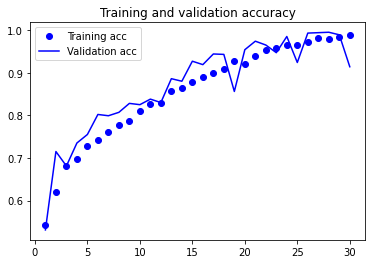

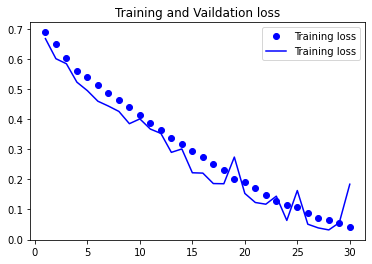

In [11]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Training loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

# 使用資料擴增法
自現有訓練樣本成更多訓練資料的方法  
```
ImageGenerator
```

In [7]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

顯示一些隨機擴充後的訓練影像

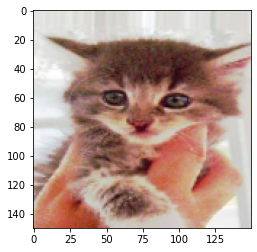

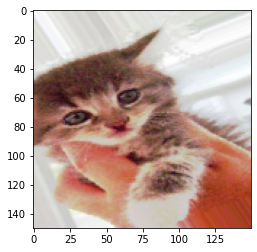

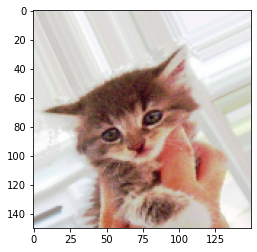

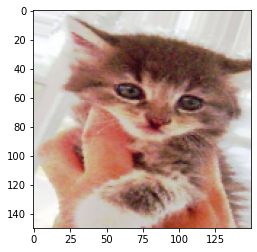

In [10]:
from keras.preprocessing import image
from matplotlib import pyplot as plt 

fnames=[os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path,target_size=(150,150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x,batch_size=1):
    plt.figure(i)
    implot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

新增Dropout層來降低發生過度適配的可能性

In [2]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

### 使用資料擴增跟丟棄法來訓練神經網路

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, )

test_datagen = ImageDataGenerator(rescale=1./255) # 驗證資料不應該進行擴充

train_generator = train_datagen.flow_from_directory(
	train_dir,    # 目標目錄
	target_size=(150, 150), # 所有圖像大小調整成 150×150 
	batch_size=50,
	class_mode='binary') # 因為使用二元交叉熵 binary_crossentropy 作為損失，所以需要二元標籤


validation_generator=test_datagen.flow_from_directory(
    test_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=50,          
    class_mode='binary'     # 因為二元交叉熵binary_crossentropy作為損失值，所以需要二元標籤
)

# 訓練
history = model.fit(   
	train_generator,
	# steps_per_epoch=100, # 一般都讓TF自行判斷，不須特別設定(在這裡加入會噴ERROR)
	epochs=100,
	validation_data=validation_generator,
    # vaildation_steps=50  #只有在指定了 steps_per_epoch时才有用。停止前要验证的总步数（批次样本）。與驗證步驟不一致時會發生計算驗證集準確度跟誤差值的ERROR
    )


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 78s 2s/step - loss: 0.7012 - acc: 0.4814 - val_loss: 0.6944 - val_acc: 0.5000
Epoch 2/100
40/40 [==============================] - 19s 473ms/step - loss: 0.6891 - acc: 0.5466 - val_loss: 0.6847 - val_acc: 0.5340
Epoch 3/100
40/40 [==============================] - 19s 473ms/step - loss: 0.6828 - acc: 0.5669 - val_loss: 0.7408 - val_acc: 0.5000
Epoch 4/100
40/40 [==============================] - 19s 472ms/step - loss: 0.6805 - acc: 0.5577 - val_loss: 0.7028 - val_acc: 0.5130
Epoch 5/100
40/40 [==============================] - 20s 500ms/step - loss: 0.6798 - acc: 0.5547 - val_loss: 0.6807 - val_acc: 0.5660
Epoch 6/100
40/40 [==============================] - 19s 475ms/step - loss: 0.6617 - acc: 0.5945 - val_loss: 0.6530 - val_acc: 0.6230
Epoch 7/100
40/40 [==============================] - 19s 470ms/step - loss: 0.6642 - acc: 0.5978 - val_loss: 0.7424

儲存模型

In [10]:
model.save('./model/cats_and_dogs_small_2.h5')

再次繪圖進行驗證

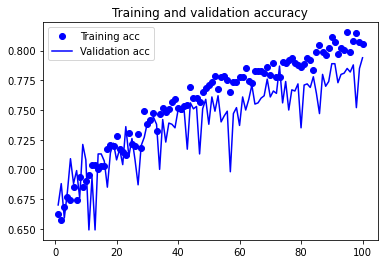

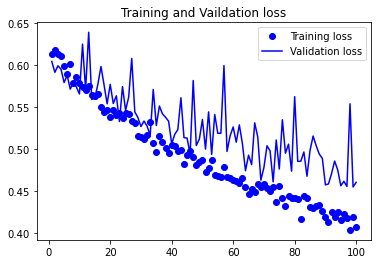

In [11]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

# 使用預先訓練的神經網路

* 特徵萃取 (feature extration)
* 微調 (fine-tuning)

## 特徵萃取
使用先前神經網路所學習到的表示法，自新的樣本中萃取出對應的特徵
  
用於影像分類的卷積神經網路的組成：
 * 卷積基底(**卷積層+池化層**)： 學習到參數的空間特徵，通用性高
 * 分類器：僅學習到該樣本對應標籤的可能機率，僅適用於model訓練時所使用的data
  
綜合上述，在實務上的做法：  
**透過convolutionalbase 卷積基底處理新資料，並以輸出結果訓練新的分類器**  
![pic5-4](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/5-4.png?raw=true)  


model層的深度決定普適程度
* 較早的神經層： 萃取局部的、高度通用的特徵圖
* 較晚的神經層： 萃取更抽象的概念(例如*貓耳朵*)

實際建立一個VGG16 model

In [1]:
from keras.applications import VGG16

conv_base  = VGG16(
    weights='imagenet',     # 初始化model的權重檢查點
    include_top=False,      # 指在頂部是否有包含密集連接的分類器
    input_shape=(150,150,3) # 提供給神經網路的影像張量的shape
    )

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

資料流動方向是由下而上，因此輸入與輸出的圖片大小是：
* 輸入層：(4,4,512) 
* 輸出層：(150,150,3) 

### 沒有資料擴增的快速萃取特徵

In [3]:
import os
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import tqdm

base_dir="./data/cats_and_dogs_small"

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')

datagen= ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    
    i=0
    for inputs_batch,labels_batch in tqdm.tqdm(generator):
        features_batch = conv_base.predict(inputs_batch) # 從批次影像中萃取特徵
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        # print(i,end=" ")
        # 當萃取的樣本數超過設定的樣本數，則執行break中斷處理
        if i*batch_size >= sample_count:
            break
    return features,labels

trian_features,train_labels = extract_features(train_dir,2000)
validation_features , validation_labels= extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

 98%|█████████▊| 49/50 [00:17<00:00,  2.87it/s]


為了提供輸出結果給分類器，需要額外進行資料展平

In [4]:
train_features = np.reshape(trian_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

建立和訓練密集連接的分類器

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,train_labels,
                epochs=30,
                batch_size=20,
                validation_data=(validation_features,validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 22ms/step - loss: 0.6812 - acc: 0.6127 - val_loss: 0.4485 - val_acc: 0.8340
Epoch 2/30
100/100 [==============================] - 1s 9ms/step - loss: 0.4525 - acc: 0.7942 - val_loss: 0.3724 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3730 - acc: 0.8322 - val_loss: 0.3391 - val_acc: 0.8590
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3317 - acc: 0.8550 - val_loss: 0.3076 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2876 - acc: 0.8885 - val_loss: 0.2944 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2711 - acc: 0.8951 - val_loss: 0.2776 - val_acc: 0.9000
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2630 - acc: 0.8977 - val_loss: 0.2691 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 1s 9ms/step - loss:

繪製結果

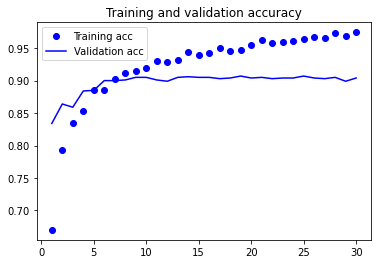

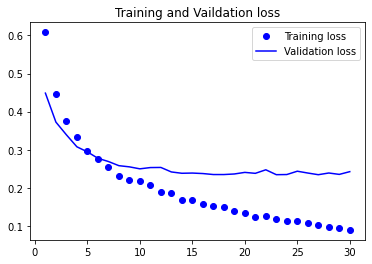

In [6]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

儘管使用相當大的丟棄率，資料在一開始就過度配適

### 資料擴增的特徵擷取
執行速度慢、成本昂貴，但允許在訓練期間使用資料擴增法。

In [7]:
from keras import models
from keras import layers
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) #展平
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### Freeze 凍結 
代表該模型將在訓練期間被禁止更新權重  
在keras中，透過設定trainable的屬性為**False**來進行凍結 卷積神經網路

In [9]:
print('This is the number of traonable weights before freezing the conv_base',len(model.trainable_weights))

This is the number of traonable weights before freezing the conv_base 30


使用此設定後，只需訓練兩個Dense層的權重。  
共有4個權重張量：每層兩個(主要權重矩陣跟偏差向量)

In [10]:
conv_base.trainable=False

In [11]:
print('This is the number of traonable weights after freezing the conv_base',len(model.trainable_weights))

This is the number of traonable weights after freezing the conv_base 4


使用資料擴增設定來訓練model

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,              # 目標目錄
    target_size=(150,150),  # 調整所有影像大小為 150 * 150
    batch_size=20,          
    class_mode='binary'  
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 66s 650ms/step - loss: 0.6208 - acc: 0.6384 - val_loss: 0.4267 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 85s 848ms/step - loss: 0.4795 - acc: 0.7865 - val_loss: 0.3561 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 75s 754ms/step - loss: 0.4182 - acc: 0.8094 - val_loss: 0.3334 - val_acc: 0.8560
Epoch 4/30
100/100 [==============================] - 85s 848ms/step - loss: 0.3943 - acc: 0.8377 - val_loss: 0.3078 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 87s 867ms/step - loss: 0.3720 - acc: 0.8324 - val_loss: 0.2934 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 85s 848ms/step - loss: 0.3631 - acc: 0.8393 - val_loss: 0.2986 - val_acc: 0.8750
Epoch 7/30
100/100 [==============================] - 85s 848ms/step - loss: 0.3585 - acc: 0.8449 - val_loss: 0.2817 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 8

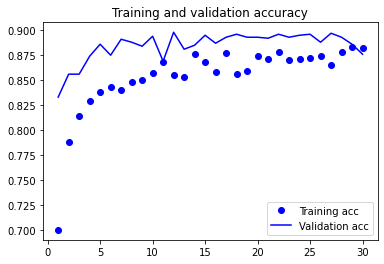

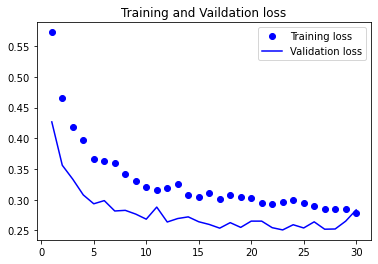

In [14]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

# 微調 (fine-tuning)
解凍一些捲基基底「頂部」的某些層  
   
① 在已經訓練過的基礎神經網路(捲基基底)上增加自定義神經網路  
② 凍結捲基基底  
③ 訓練步驟1增加的部分  
④ 解凍捲基基底中的某些層  
⑤ 共同訓練解凍的這幾層和分類器   

In [15]:
from keras import models
from keras import layers
from keras.applications import VGG16

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

 **目標**：微調後面3個卷積層  


將所有層凍結到指定層為止

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'blocks_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

微調神經網路

In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps =50
)

D:\Anacanda\lib\site-packages\tensorflow\python\keras\engine\training.py:1879: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/100
100/100 [==============================] - 79s 778ms/step - loss: 0.2857 - acc: 0.8766 - val_loss: 0.2497 - val_acc: 0.8960
Epoch 2/100
100/100 [==============================] - 85s 848ms/step - loss: 0.2786 - acc: 0.8809 - val_loss: 0.2580 - val_acc: 0.8940
Epoch 3/100
100/100 [==============================] - 85s 848ms/step - loss: 0.2475 - acc: 0.9000 - val_loss: 0.2560 - val_acc: 0.8960
Epoch 4/100
100/100 [==============================] - 85s 849ms/step - loss: 0.2646 - acc: 0.8860 - val_loss: 0.2475 - val_acc: 0.8950
Epoch 5/100
100/100 [==============================] - 85s 848ms/step - loss: 0.2838 - acc: 0.8789 - val_loss: 0.2494 - val_acc: 0.8930
Epoch 6/100
100/100 [====================

繪圖進行驗證

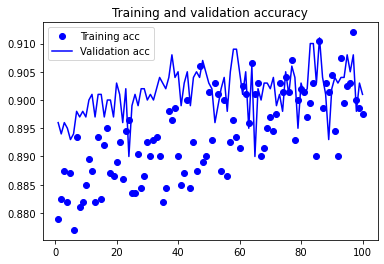

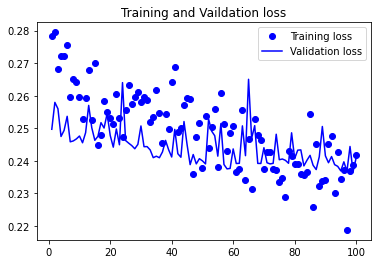

In [19]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label="Training acc")
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Vaildation loss")
plt.legend()

plt.show()

繪製平滑曲線

In [26]:
def smooth_curve(points,factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            prevoius = smoothed_points[-1]
            smoothed_points.append(prevoius*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

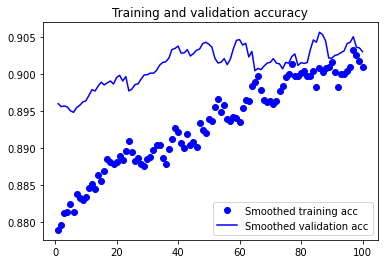

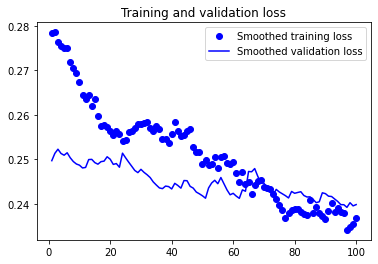

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(epochs,smooth_curve(acc),'bo',label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc),'b',label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,smooth_curve(loss),'bo',label='Smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss),'b',label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

用測試資料來評估微調後的model

In [30]:
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss , test_acc = model.evaluate_generator(test_generator,steps=50)
print('test acc', test_acc)

Found 1000 images belonging to 2 classes.
D:\Anacanda\lib\site-packages\tensorflow\python\keras\engine\training.py:1912: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
test acc 0.9010000228881836


# 視覺化呈現卷積神經網路學習的內容  
① 視覺化中間層convent的輸出(中間啟動函數的輸出)  
② 視覺化卷積神經網路過濾器  
③ 視覺化類別激活熱圖

## 中間層輸出的視覺化
再給定輸入影像的情況下，繪製並顯示出convent各個卷積層和池化層的特徵圖。  
視覺化的正確方法是將每個channel的特徵進行編碼並獨立繪製成2D圖形

載入已建立並儲存的model

In [2]:
from keras.models import load_model
model = load_model('./model/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 視覺化卷積神經網路過濾器
**結論**：  
各層萃取的特徵隨著層的深度而變得越來越抽象  
可將神經網路視為一種**資訊蒸餾管線(information distillation pipeline)**

取一張不是之前convent訓練過的貓圖片作為輸入(測試集)

In [3]:
img_path = './data/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np 

img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


顯示測試影像

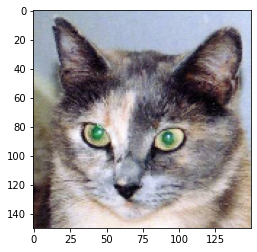

In [4]:
import matplotlib.pyplot as plt 

plt.imshow(img_tensor[0])
plt.show()

為了萃取欲觀看的特徵圖，將建立一個Keras model  
他將以批次量的影像作為輸入，並將所有卷積層與池化層的啟動函數職輸出

### 多層輸出的model
在本例中有一個輸入但產生8個輸出

In [5]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 萃取model前八層的輸出張量

for op in layer_outputs:
    print(op)

# 用一個輸入張量與輸出張量的list來建構一個新model
activation_model = models.Model(inputs=model.input,outputs=layer_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 148, 148, 32), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 74, 74, 32), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 72, 72, 64), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 36, 36, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 34, 34, 128), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
KerasTensor(type_

在predict mode 下執行model

In [6]:
activations = activation_model.predict(img_tensor)
print(len(activations))

8


範例：第一層卷積層的啟動函數輸出張量

In [7]:
first_layer_activation =activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


視覺化第四個channel的響應圖

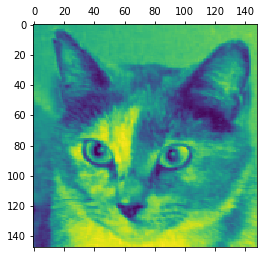

In [8]:
import matplotlib.pyplot as plt 

plt.matshow(first_layer_activation[0,:,:,4],cmap='viridis')

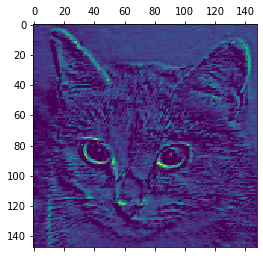

In [9]:
import matplotlib.pyplot as plt 

plt.matshow(first_layer_activation[0,:,:,7],cmap='viridis')

視覺化每個啟動函數輸出中每個channel的響應圖

<ipython-input-11-c8e250a9db96>:20: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


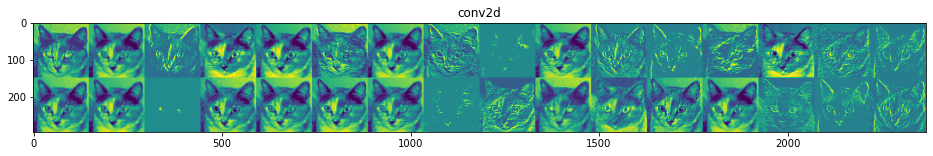

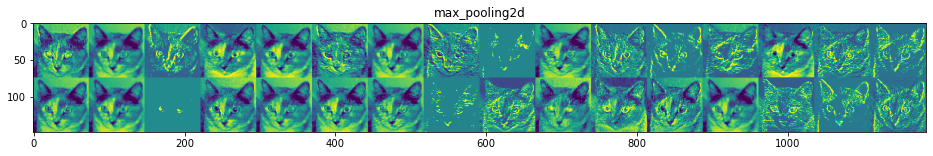

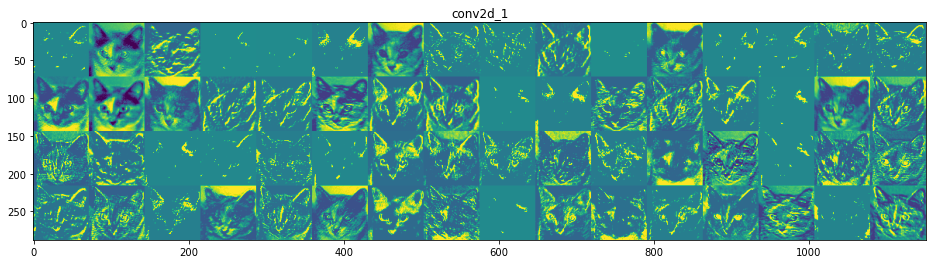

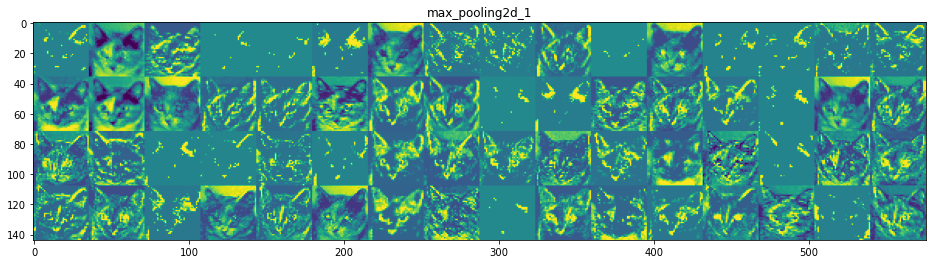

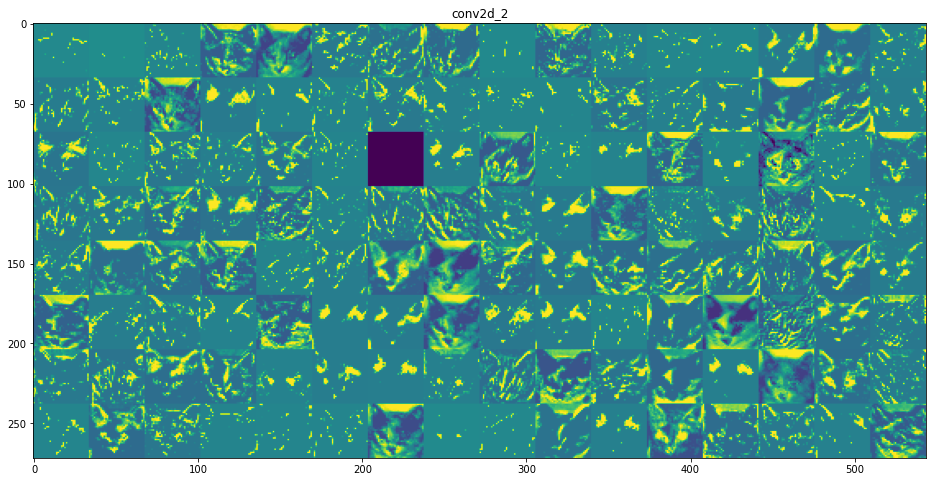

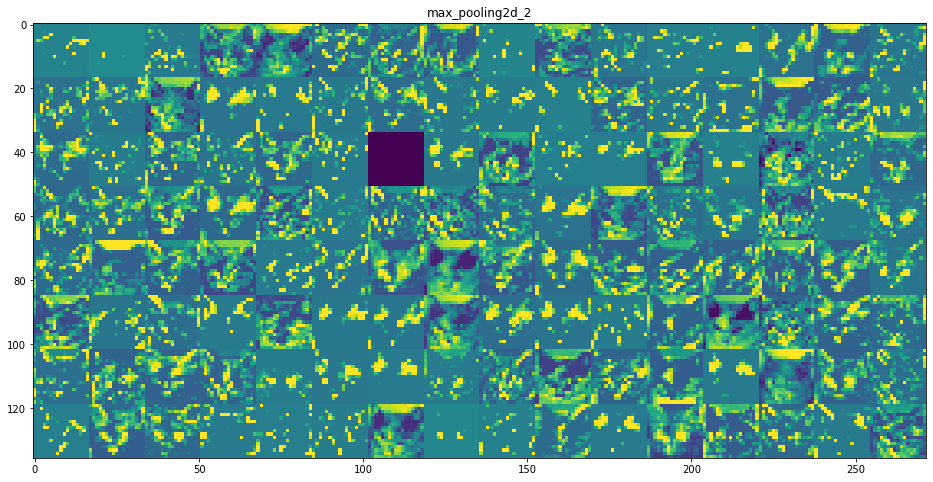

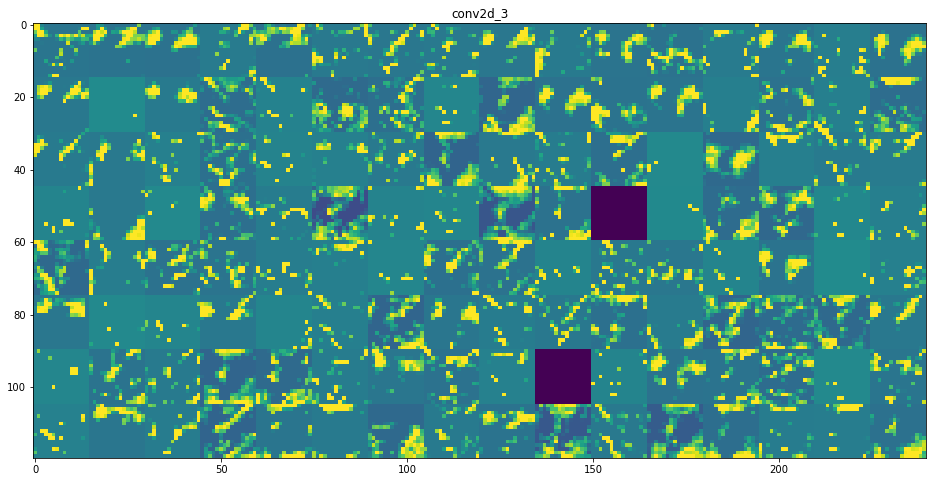

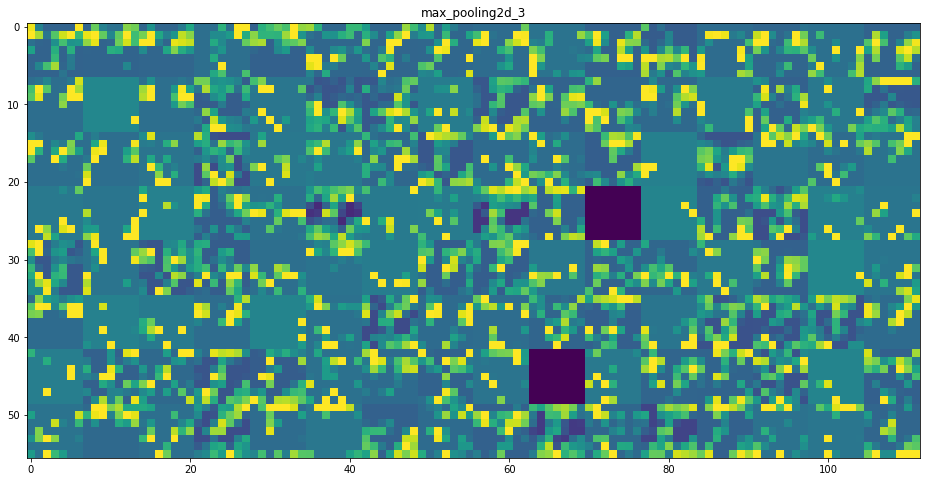

In [11]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

image_per_row = 16 #在大圖中，每個橫列可以放16張圖

for  layer_name,layer_activation in zip(layer_names,activations):

    n_features = layer_activation.shape[-1]   # 某層輸出張量中的特徵數量
    size = layer_activation.shape[1]          # 取得響應圖的尺寸大小

    n_cols = n_features // images_per_row
    display_gird = np.zeros(( size*n_cols , images_per_row*size ))

    for col in range(n_cols):
        for row in range(image_per_row):
            # 對圖片進行後處理，使其在視覺上更美觀
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_gird[ col * size : (col+1)*size,
                          row * size : (row+1)*size] = channel_image #將處理好的圖片放入窗格中
    
    scale = 1. / size
    plt.figure(figsize = (scale*display_gird.shape[1],scale*display_gird.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_gird,aspect = 'auto',cmap='viridis')


* 第一層：各種邊緣偵測器的集合，啟動函數的輸出幾乎保留了初始影像中的所有資訊
* 隨著層數上升，輸出變得越來越抽象，但帶出較多關於影像適合種類別的資訊
* 啟動函數輸出的稀疏性隨著層的深度而增加

## 視覺化convent 的 filter
看個filter要過濾的視覺圖案，並透過改變輸入影像的像素使響應最大化(即梯度上升)

#### 建立損失函數
透過呼叫[keras的後端(backend)](https://keras.io/backend/)


In [12]:
from keras.applications import VGG16
from keras import backend as K 
# 解決 tensorflow backend問題：
# https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta/66222183
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet',include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index]) # 定義損失函數張量，為該層輸出張量數值取平均

透過keras後端模組的gradients()函數  
來取得損失函數張量相對於model輸入的梯度

In [13]:
grads = K.gradients(loss,model.input)[0]
# gradient()會回傳一個由張量組成的list，在本例中list的大小是1
# 因此只取出第一個元素，即索引位置是0的元素 

透過將梯度張量除以其L2張量，對梯度張量進行正規化

In [14]:
grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5) # 加入偏差項避免輸出數值為0

In [17]:
iterate = K.function([model.input],[loss,grads])

import numpy as np 
loss_value , grads_value = iterate([np.zeros((1,150,150,3))])

In [19]:
input_img_data = np.random.random((1,150,150,3))*20+128.

step = 1.
for i in range(40): # 操作梯度上升40步
    loss_value , grads_value = iterate([input_img_data])
    input_img_data += input_img_data*step # 以朝向最大化損失值調整輸入圖像

#### 建立將圖像張量轉換為可用的影像格式的自訂函式
對張量進行**後處理(posprocessing)**，將其轉換成可顯示的影像格式

In [20]:
def deprocess_image(x):
    # 張量正規化：以0為中心，確保std為0.1
    x -= x.mean()
    x /= (x.std()+1e-5)
    x *= 0.1

    # 修正為[0,1]
    x += 0.5
    x = np.clip(x,0,1)

    # 轉換成RGB陣列
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

#### 建立過濾器視覺化的函數
將層的名稱和過濾器索引作為輸入參數，並回傳一個有效的影像張量  
表示最大化指定過濾器啟動函數輸出的pattern

In [21]:
def generate_pattern(layer_name,filter_index,size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.square(K.square(grads)))+1e-5)
    iterate = K.function([model.input],[loss,grads])

    input_img_data = np.random.random((1,size,size,3))*20+128.

    step = 1.
    for i in range(40):
        loss_value , grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
    
    img = input_img_data[0]
    return deprocess_image(img)

查看block3_conv1層的過濾器0的響應圖

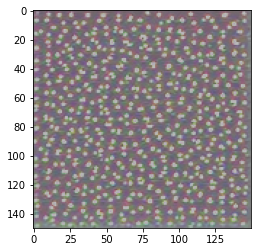

In [22]:
plt.imshow(generate_pattern('block3_conv1',0))

產生一層所有過濾器響應的pattern

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


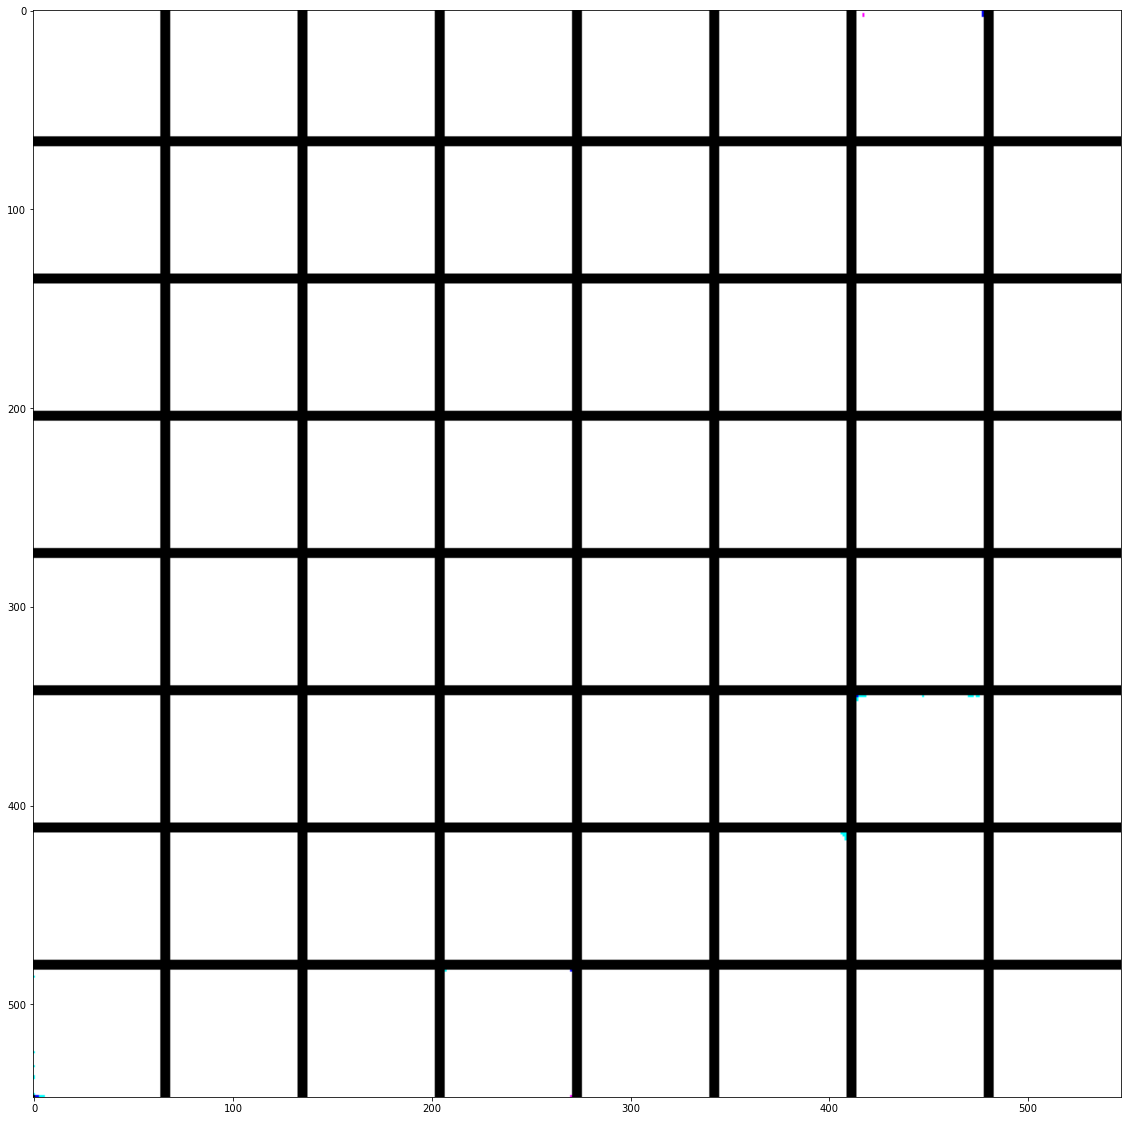

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


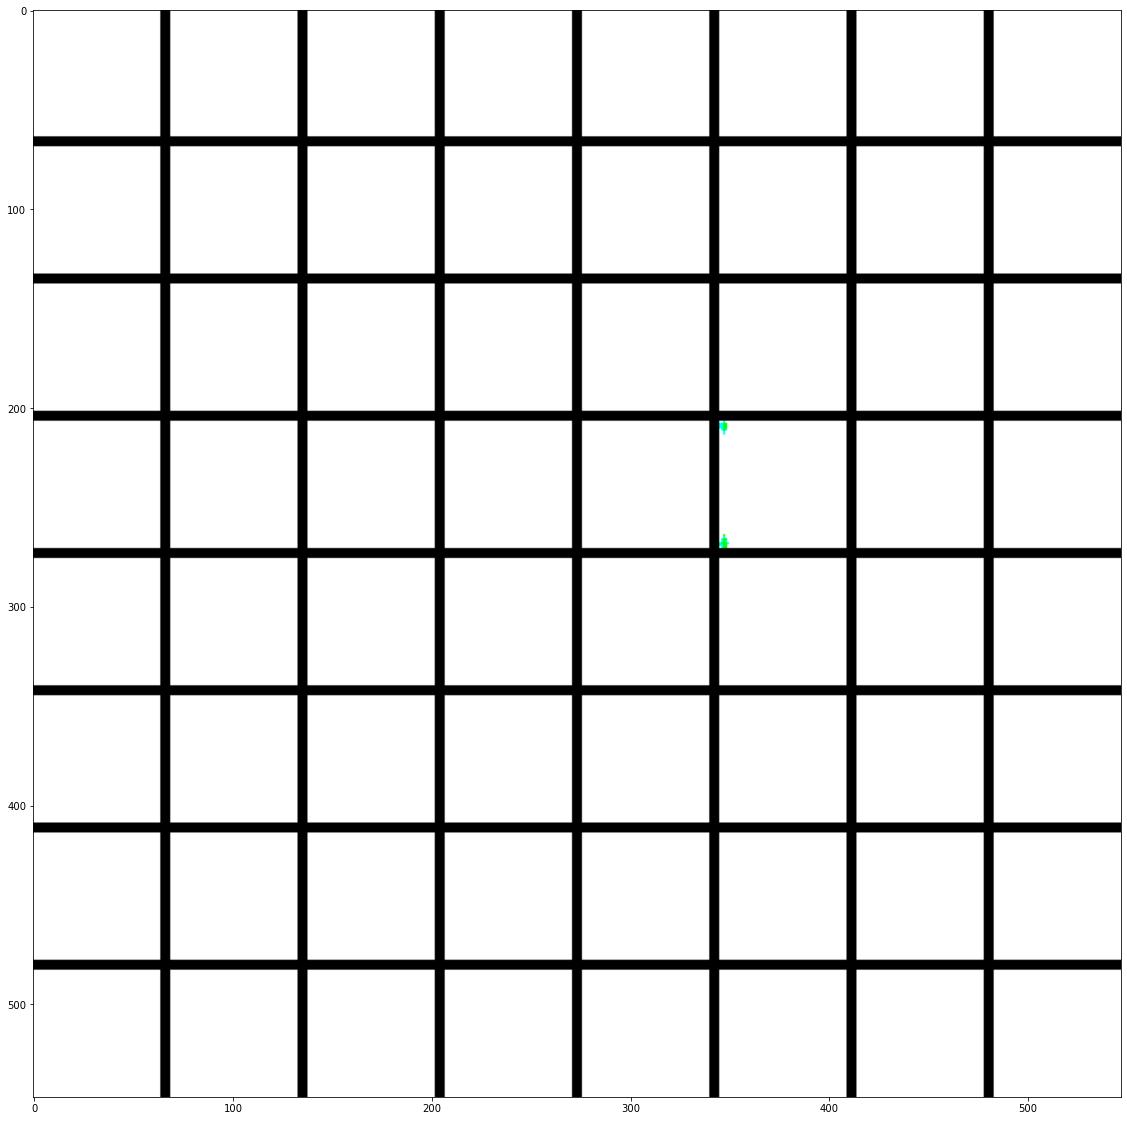

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


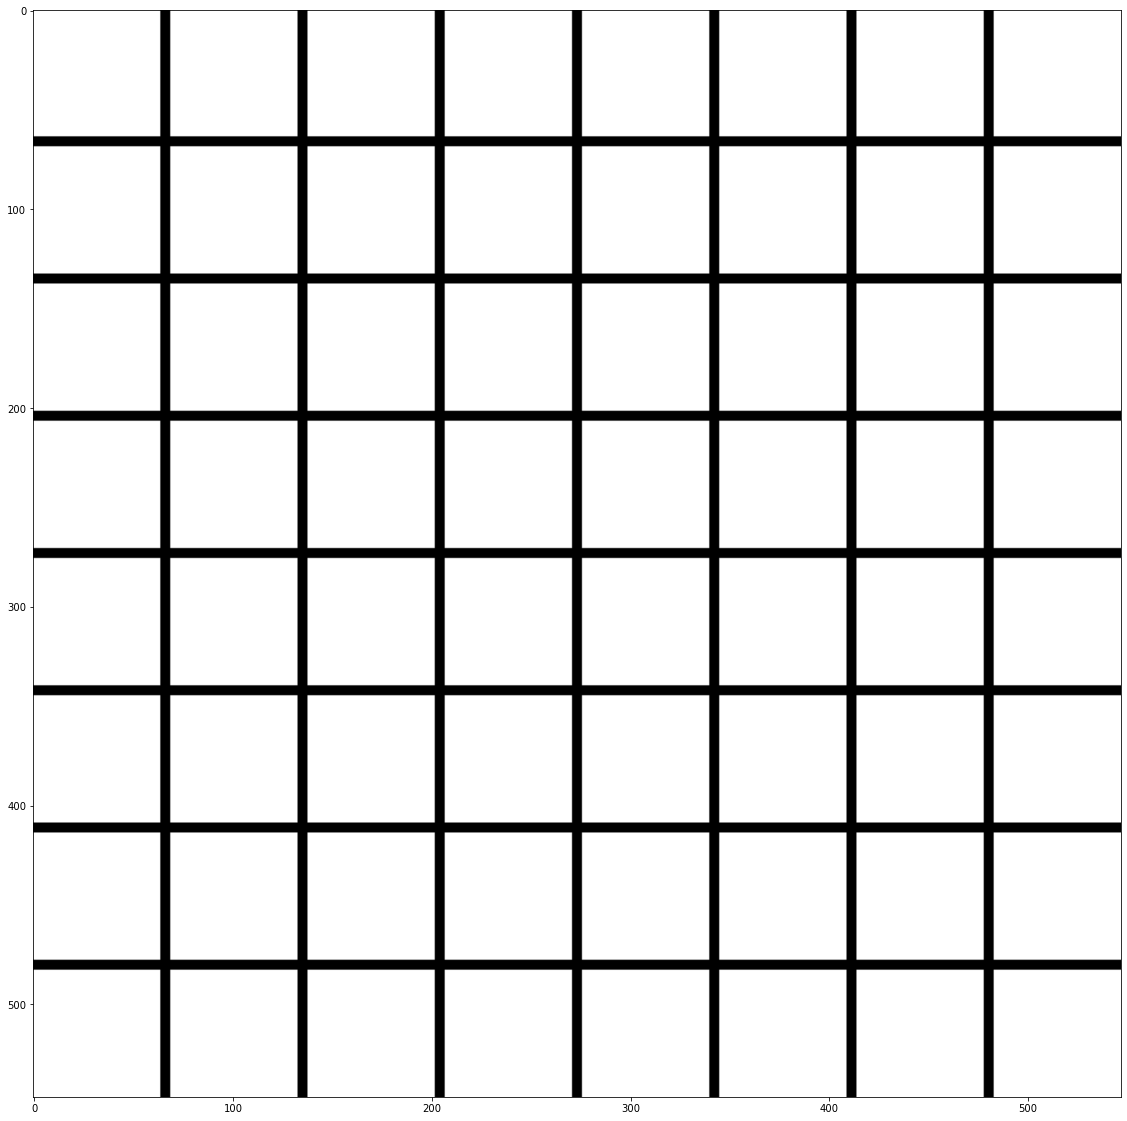

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


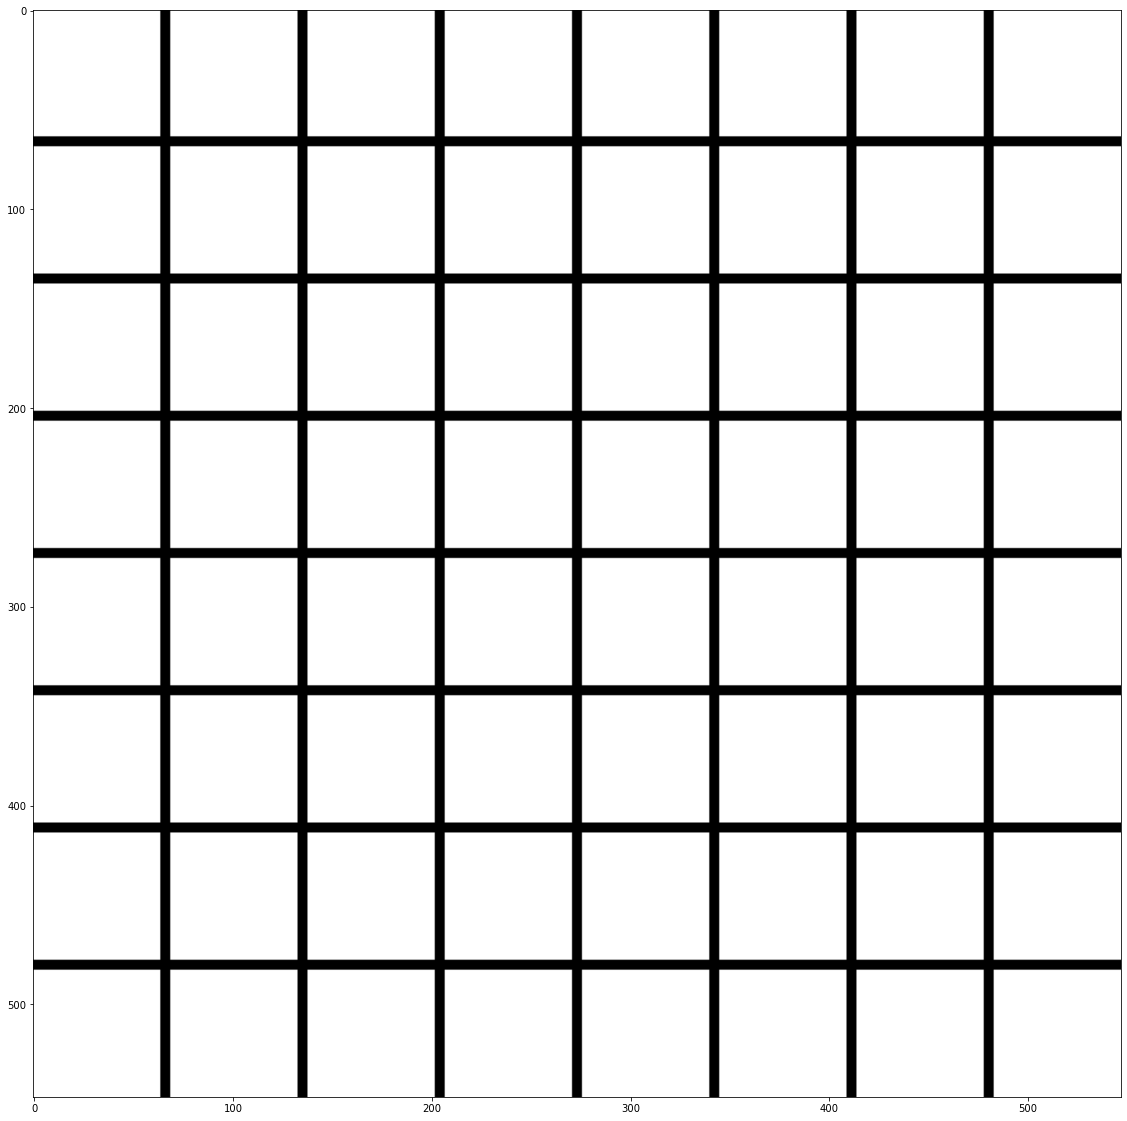

In [28]:
import numpy as np 

for  in ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']:
    size = 64
    margin = 5

    results  = np.zeros((8*size+7*margin,8*size+7*margin,3))

    for i in range(8):
        for j in range(8):
            
            filter_img = generate_pattern(layer_name,i+(j*8),size=size) # 在layer_name中產生過濾器 i+(j*8) 的 pattern
            
            # 將結果放置在結果網格的方形(i,j)之中
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start+size
            vertical_start = j*size + j* margin
            vertical_end = vertical_start+size
            
            results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img
    
    plt.figure(figsize=(20,20))
    plt.imshow(results)
    plt.show()

## 視覺化類別熱圖

In [58]:

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss,test_acc = model.evaluate_generator(test_generator,steps=50)
print('test acc:',test_acc)
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-58-375bedfe187e>, line 10)